# Final Project
## CSCE 633
## Arya Rahmanian
## Summer 2024

### Load Dataset

In [1]:
import pandas as pd

splits = {'train': 'yelp_review_full/train-00000-of-00001.parquet', 'test': 'yelp_review_full/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/Yelp/yelp_review_full/" + splits["train"])

In [2]:
# get train and test df
train_df = pd.read_parquet("hf://datasets/Yelp/yelp_review_full/" + splits["train"])
test_df = pd.read_parquet("hf://datasets/Yelp/yelp_review_full/" + splits["test"])

# randomly select data points and split data into train, test, and valid
train_data = train_df.sample(n=10000, random_state=42)
val_data = train_df.drop(train_data.index).sample(n=1000, random_state=42)
test_data = test_df.sample(n=2000, random_state=42)

print("Training Data:")
print(train_data.head())

print("\nTest Data:")
print(test_data.head())

Training Data:
        label                                               text
177288      0  First of all i'm not a big fan of buffet, i tr...
238756      1  Thanks Yelp. I was looking for the words to de...
604225      2  Service was so-so. They were receiving a deliv...
2838        2  Stamoolis Brothers is one of the Strip Distric...
586957      0  I want to give a 2 stars because the service s...

Test Data:
       label                                               text
33553      4  Came a few days ago for a lease, wasn't sure o...
9427       0  I chose the 4 Queens for my visit to Las Vegas...
199        3  I went here on the day of a wedding (I'm from ...
12447      1  Isn't it strange how the little things can sou...
39489      4  Visit here several times a year. The food is a...


In [3]:
import numpy as np
"""
def load_glove_embeddings(file_path):
    embedding_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embedding_dict[word] = vector
    return embedding_dict


glove_file = 'glove.twitter.27B.50d.txt'  

embedding_dict = load_glove_embeddings(glove_file)
"""

"\ndef load_glove_embeddings(file_path):\n    embedding_dict = {}\n    with open(file_path, 'r', encoding='utf-8') as f:\n        for line in f:\n            values = line.split()\n            word = values[0]\n            vector = np.array(values[1:], dtype='float32')\n            embedding_dict[word] = vector\n    return embedding_dict\n\n\nglove_file = 'glove.twitter.27B.50d.txt'  \n\nembedding_dict = load_glove_embeddings(glove_file)\n"

### Data Pre-Processing

In [4]:
def map_labels(stars):
    return 0 if stars < 3 else 1

# create our label column
train_data['label'] = train_data['label'].apply(map_labels)
test_data['label'] = test_data['label'].apply(map_labels)
val_data['label'] = val_data['label'].apply(map_labels)


In [5]:
import re
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

#function to preprocess text
def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing to the 'text' column
train_data['text'] = train_data['text'].apply(preprocess_text)
val_data['text'] = val_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to C:\Users\Arya
[nltk_data]     Rahmanian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Tokenize and Pad Text Vectors

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
val_sequences = tokenizer.texts_to_sequences(val_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

# Define a maximum length for sequences
max_length = 150

# Pad/Truncate sequences to the same length
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Display the shape of the padded sequences
print(train_padded.shape)
print(val_padded.shape)
print(test_padded.shape)

(10000, 150)
(1000, 150)
(2000, 150)


### Build Model

#### Transformer

In [7]:
import torch.nn as nn
class TransformerSentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, max_length, dropout=0.1):
        super(TransformerSentimentClassifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = self.create_positional_encoding(max_length, embed_dim)
        
        encoder_layers = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)
        
    def create_positional_encoding(self, max_length, embed_dim):
        pe = torch.zeros(max_length, embed_dim)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-np.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_length, embed_dim)
        return nn.Parameter(pe, requires_grad=False)
    
    def forward(self, x, mask=None):
        x = self.embedding(x)  # (batch_size, max_length, embed_dim)
        x = x + self.positional_encoding[:, :x.size(1), :]
        x = self.layer_norm(x)
        
        x = x.permute(1, 0, 2)  # (max_length, batch_size, embed_dim)
        x = self.transformer_encoder(x, src_key_padding_mask=mask)  # (max_length, batch_size, embed_dim)
        
        x = x.mean(dim=0)  # (batch_size, embed_dim)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # (batch_size, num_classes)
        return x

    def generate_padding_mask(self, inputs, pad_token_id):
        mask = (inputs == pad_token_id)
        return mask

In [8]:
import torch
import torch.nn.functional as F

pad_token_id = 0
BATCH_SIZE = 128
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embed_dim = 128
num_heads = 4
hidden_dim = 256
num_layers = 2
num_classes = 2 

# build model
model = TransformerSentimentClassifier(vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, max_length)
inputs = torch.randint(0, vocab_size, (BATCH_SIZE, max_length))
mask = model.generate_padding_mask(inputs, pad_token_id)
outputs = model(inputs, mask)

E:\anaconda\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


#### Create Tensors and Dataloaders

In [9]:
from torch.utils.data import Dataset, TensorDataset, DataLoader

# convert to Torch tensors
X_train = torch.tensor(train_padded, dtype=torch.long)
y_train = torch.tensor(train_data['label'].values, dtype=torch.long)
X_val = torch.tensor(val_padded, dtype=torch.long)
y_val = torch.tensor(val_data['label'].values, dtype=torch.long)
X_test = torch.tensor(test_padded, dtype=torch.long)
y_test = torch.tensor(test_data['label'].values, dtype=torch.long)


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Training

In [10]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW, Adam, SGD
from sklearn.model_selection import train_test_split

# lists to store training metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# constants hyper params
EPOCHS = 7
LEARNING_RATE = 0.001

# init optimizer, and loss function
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_val_accuracy = 0.0
best_model_state_dict = None

In [11]:
# training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # validation
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_predictions / total_predictions
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state_dict = model.state_dict()


E:\anaconda\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1/7, Loss: 0.6217, Accuracy: 0.6493
Validation Loss: 0.5302, Validation Accuracy: 0.7360
Epoch 2/7, Loss: 0.4779, Accuracy: 0.7711
Validation Loss: 0.4654, Validation Accuracy: 0.7880
Epoch 3/7, Loss: 0.3857, Accuracy: 0.8279
Validation Loss: 0.4486, Validation Accuracy: 0.8020
Epoch 4/7, Loss: 0.3124, Accuracy: 0.8703
Validation Loss: 0.5173, Validation Accuracy: 0.7840
Epoch 5/7, Loss: 0.2369, Accuracy: 0.9031
Validation Loss: 0.4862, Validation Accuracy: 0.7710
Epoch 6/7, Loss: 0.1768, Accuracy: 0.9348
Validation Loss: 0.6294, Validation Accuracy: 0.7930
Epoch 7/7, Loss: 0.1158, Accuracy: 0.9600
Validation Loss: 0.5799, Validation Accuracy: 0.7940


In [12]:
model.load_state_dict(best_model_state_dict)

<All keys matched successfully>

### Plot Training Metrics

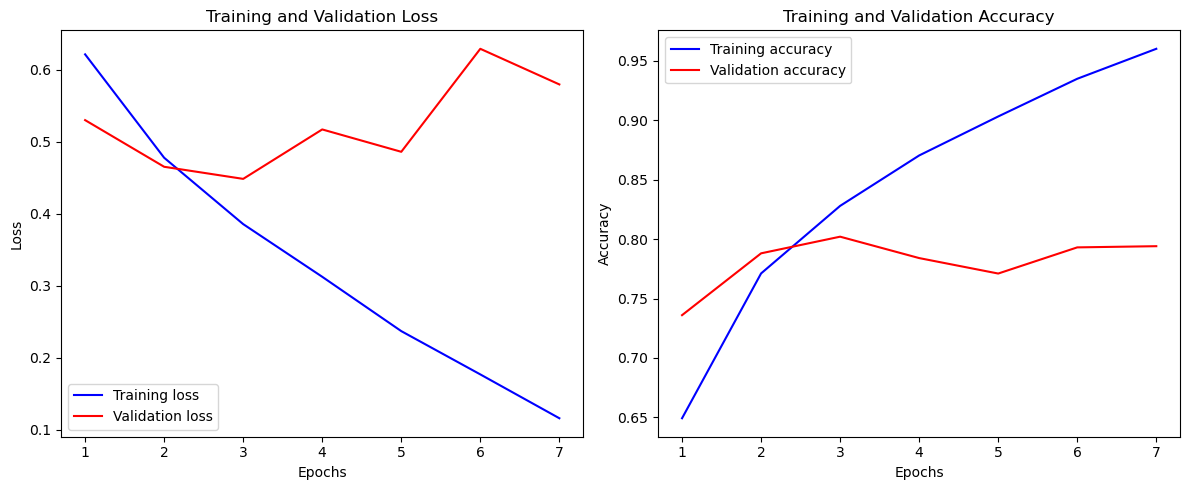

In [13]:
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Testing the Model

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# evaluate model
model.eval()

# track loss and accuracy
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

# lists to store true and predicted labels for metric calculation
all_labels = []
all_preds = []

# test
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

        # store true and predicted labels
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# calc average test loss and accuracy
test_loss /= len(test_loader.dataset)
test_accuracy = correct_predictions / total_predictions

# calculate additional metrics
precision = precision_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Test Loss: 0.6160
Test Accuracy: 80.10%
Precision: 0.76
Recall: 0.75
F1 Score: 0.76
Confusion Matrix:
[[985 195]
 [203 617]]
